<p style="text-align: center;" ><font size="+3"><u><b>Laboratory 4 Part 2: System Identification and Optimization</u></b></p>

<p style="text-align: left;" ><font size="+1"><b>Group #: ___________   Team Members: _______________  </b></p>

<p style="text-align: left;" ><font size="+1"><b>Optimization Basics</b></p>

<div class="alert alert-block alert-warning">
<font color=black>

When you define an optimization problem you must consider three main elements: <br/>
1) the **optimization parameters**: the variables you are trying to find, <br/>
2) the **objective function**: a function (of the optimization parameters) of which you are trying to find minimum (or maximum); this is often a fitting function (e.g. a measure of error in a data fit), and <br/>
3) the **optimization algorithm/optimizer** – which is the particular algorithm we are using to find the optimum. Mathematically, we may write the optimization as
\begin{equation}
x^{*} = \underset{x}{\operatorname{argmin}}  f(x)
\end{equation} 
    
where $x$ is a vector of optimization parameters and $f(x)$ is the objective function. The minimization is defined implicitly and needs to be solved using some algorithm. <br/>
    
An example of how to code a simple optimization problem in Python is provided on Blackboard (`Lab4 Optimization Example.ipynb`). Run the code and understand the output, what the code is doing, and how to formulate a general optimization problem with the help of descriptions provided below.
</font> 
</div>

<p style="text-align: left;" ><font size="+1"><b>System Identification in Simulated Data</b></p>

<div class="alert alert-block alert-warning">
<font color=black>

We are going to use the same kind of procedure as outlined above to find out certain parameters in a physical microscope system. To do this we need a functional form of our data simulator. Specifically, you need to convert the simulation code you wrote from Part 1 of this lab to a function called `make_psf`. The inputs to the function are radius of the exit pupil (`r`), coefficients to the Zernike polynomials (`coefs`) that define any system aberrations, the corresponding mode indices of the Zernike polynomials (`mode_indices`), and size of the PSF you want to make (`nxy`). The output of the function should be a simulated PSF. For example, you should be able to execute the following command:
    
`def make_psf(r, coefs, mode_indices, nxy):` <br/>
`    # code block computing psf`<br/>
`    return psf`<br/>

Call the function and confirm you get the same results as before. <br/>
    
Next, we’ll write an objective function. Create a function in Python called `objfunc`. The inputs to the function are:
1) the optimization parameters in vector form (`xv`). Note that all the parameters need to be in a single vector, and the vector needs to be the first argument to the objective function
2) the PSF you want to fit to (a simulated PSF in this case, or the measured PSF in real data, `mpsf`), and 
3) the mode indices of the Zernike polynomials (`mode_indices`) <br/>
    
The objective function to the optimization is sum of squared error between the estimated PSF and PSF you want to fit to (`mpsf`). In a separate script, write the objective function with the following syntax:

`def objfunc(xv, mpsf, mode_indices):` <br/>
`    # code block computing the value of the objective function` <br/>
`    return val` <br/>

Note that our model did not account for the magnitude of the PSF. Before calculating the sum of squared error, normalize both PSFs to the same scale, e.g., between 0 and 1. <br/>

In your optimization routine, similar to the example in `Lab4 Optimization Example.ipynb`, display a figure containing `mpsf`, the estimated PSF (from `make_psf`), and the absolute difference between the two with a colorbar. This will allow you to see how the optimization is doing in real time. <br/><br/>

</font> 
</div>

<div class="alert alert-block alert-success">
<font color=black>

1. In summary, your objective function should contain the following three parts:

- Parse `xv`
- Generate model prediction of PSF using parsed `xv` 
- Normalize `mpsf` and the PSF from 2) and calculate and return the sum of squared error between the two (e.g. over all pixels)

Show your code below:

</font> 
</div>

In [45]:
import numpy as np
from zernike import zernike 
import cma
import matplotlib.pyplot as plt

def make_psf(coefs, mode_indices, nxy):
    r = coefs[0]
    lambd = 540E-6  # setup
    zi = 190.45        # setup
    sampling = 0.2
    x = np.linspace(-1, 1, nxy)
    X, Y = np.meshgrid(x, x)

    fx = np.fft.fftshift(np.fft.fftfreq(nxy, d=sampling))
    fy = np.fft.fftshift(np.fft.fftfreq(nxy, d=sampling))

    FX, FY = np.meshgrid(-lambd*zi*fx, -lambd*zi*fy)
    H_amp = (FX**2 + FY**2) < r**2

    z_sum = zernike(-lambd * zi * fx / r, -lambd * zi * fy / r, mode_indices, coefs[1:])
    phase = np.exp(-1j * 2 * np.pi * z_sum)

    H = H_amp * phase

    h = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H)))
    psf = np.abs(h)**2
    psf /= psf.sum()

    return psf


def objfunc(xv, mpsf, mode_indices):
    nxy = mpsf.shape[0]
    est_psf = make_psf(xv, mode_indices, nxy)

    mpsf_norm = mpsf / mpsf.max()
    est_psf_norm = est_psf / est_psf.max()

    val = np.sum((mpsf_norm - est_psf_norm) ** 2)
    return val

def show_optimization_result(mpsf, est_psf):
    diff = np.abs(mpsf - est_psf)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axs[0].imshow(mpsf, cmap='coolwarm')
    axs[0].set_title('Measured PSF')
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(est_psf, cmap='coolwarm')
    axs[1].set_title('Estimated PSF')
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(diff, cmap='coolwarm')
    axs[2].set_title('Difference')
    fig.colorbar(im2, ax=axs[2])

    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-success">
<font color=black>

2. Use your `make_psf` function to generate a PSF from part 1 of this lab, for example: 
    
`mode_indices = [7, 8]`<br/>
`coefs = [0.05, -0.2]`<br/>

Assume that you know the Zernike modes but do not know the coefficients, use the optimization routine to see if you can recover the coefficients.
    
A few tricks to help the optimization:
- Have good initial guesses (close to the final solution) are important
- When computing the objective function, you can zoom in to a region of interest containing the PSF instead of calculating sum of squared error over the entire image <br/>
- Show an image of both PSFs and their absolute difference

</font> 
</div>

In [46]:
mode_indices = [7, 8]
true_coefs = [0.1, 0.05, -0.2]
nxy = 256
initial_guess = [0.1, 0.1, -0.1]

# Simulate true and initial PSFs
mpsf = make_psf(true_coefs, mode_indices, nxy)


# --- CMA-ES optimization ---
sigma0 = 0.05
opts = {'tolfun': 1e-8, 'tolx': 1e-5, 'popsize': 10, 'verb_disp': 1}

es = cma.CMAEvolutionStrategy(initial_guess, sigma0, opts)
fit = np.empty(opts['popsize'])

while not es.stop():
    new_solutions = es.ask()
    for i, sol in enumerate(new_solutions):
        fit[i] = objfunc(sol, mpsf, mode_indices)
    es.tell(new_solutions, fit)
    es.disp(1)

# result
xopt = es.result[0]

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3 (seed=636516, Fri Apr 25 10:59:37 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 6.124866816609521e+00 1.0e+00 5.53e-02  5e-02  6e-02 0:00.2
    2     20 6.567506824880581e+00 1.5e+00 6.06e-02  5e-02  8e-02 0:00.3
    3     30 3.587385529475563e+00 1.9e+00 5.59e-02  4e-02  7e-02 0:00.5
    4     40 2.716292738500672e+00 2.1e+00 5.89e-02  4e-02  8e-02 0:00.6
    5     50 2.490952406686301e+00 2.5e+00 5.46e-02  3e-02  7e-02 0:00.8
    6     60 1.281932339448039e+00 2.9e+00 4.76e-02  2e-02  5e-02 0:01.0
    7     70 3.413152015042441e+00 2.9e+00 3.91e-02  2e-02  4e-02 0:01.2
    8     80 1.407739378298799e+00 2.6e+00 3.23e-02  1e-02  3e-02 0:01.3
    9     90 2.636578677080152e-01 2.5e+00 2.54e-02  7e-03  2e-02 0:01.5
   10    100 2.948748866113257e-01 2.9e+00 2.30e-02  5e-03  2e-02 0:01.6
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    110 2.863154897202727e-01 

<div class="alert alert-block alert-success">
<font color=black>

3. Show the plot of the simulated PSF from `make_psf` with the Zernike modes and coefficients you used. What is the coefficient you obtained from the optimization? What does the optimized or estimated PSF look like?

</font> 
</div>

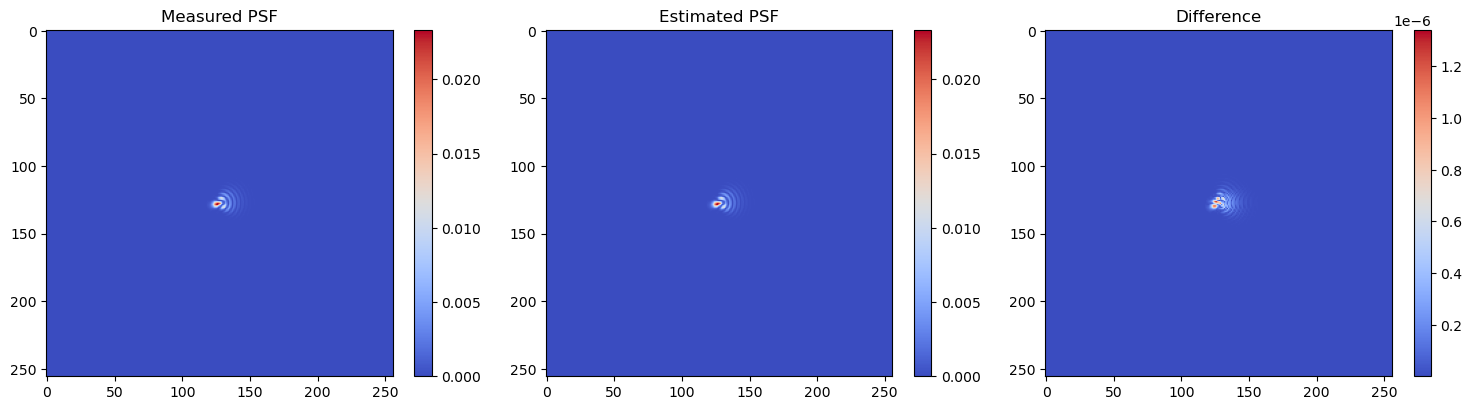

In [47]:

recovered_psf = make_psf(xopt, mode_indices, 256)    # create new recovered PSF
show_optimization_result(mpsf, recovered_psf)

<p style="text-align: left;" ><font size="+1"><b>System Identification in Real Data</b></p>

<div class="alert alert-block alert-warning">
<font color=black>
Real data are not as “clean” as simulated data. There are noise, detector non-idealities, and other aberrations we might not be modeling. Let us first get our model to be as close to the real system as possible.
</font> 
</div>

<div class="alert alert-block alert-success">
<font color=black>

1. For all data collection below, use the green fiter. 
    
    Calculate the image distance of your system. (Hint: you can used the magnification in lab 3 and the focal length of the lens in lab 1) <br/> Show your calculations below.
What is the image distance (`zi`)? Note that you have to solve for both object distance and image distance using magnification and focal length of the lens to get image distance (lecture notes from Lab 1).

Assign the `zi` variable in your `make_psf` function to the value calculated above. Also make sure the wavelength of light ($λ$) is correctly modeled.
</font> 
</div>

$M = \frac{z_i}{z_o}$ \
$z_0 = \frac{z_i}{M}$ \
\
$\frac{1}{f} = \frac{1}{z_o} + \frac{1}{z_i}$ \
$\frac{1}{f} = \frac{M}{z_i} + \frac{1}{z_i}$ \
$z_i = (1+M)\times{f}$

f = 31.75
M = 5.0

$\therefore z_i = 190.5$ 


<div class="alert alert-block alert-warning">
<font color=black>

We don’t know the exact size of the exit pupil. Let’s estimate that first using **in-focus** data at wide open aperture.
</font> 
</div>

<div class="alert alert-block alert-success">
<font color=black>

2. Perform an estimation of the exit pupil size and the two Zernike tilt parameters (to ensure subpixel centering of your PSF). Paste below the measured PSF, estimated PSF, and the size of the aperture from your optimization. <br/><br/>
HINTS: This optimization is nonlinear and highly subject to local optima. 
- You will want to start with some good starting guesses in order to find the correct solution. 
- This includes a good guess of the exit pupil size and of the tilt parameters. 
- Recall that the tilts should be close to zero if your PSF is properly centered.
- The parameter `sigma0` in the `options` parameter passed to CMA-ES is a variance that controls the level of randomness in the search. If your search appears to get stuck far from an optima, you might want to increase this value.

</font> 
</div>

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 3 (seed=669154, Fri Apr 25 11:00:35 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 5.322600219435274e+01 1.0e+00 6.21e-02  6e-02  8e-02 0:00.1
    2     24 5.205711837087082e+01 2.0e+00 8.88e-02  7e-02  1e-01 0:00.2
    3     36 4.521883845703724e+01 2.0e+00 1.03e-01  8e-02  1e-01 0:00.3
    4     48 4.536441450652543e+01 1.7e+00 1.06e-01  7e-02  1e-01 0:00.4
    5     60 4.926882373124212e+01 1.6e+00 9.70e-02  7e-02  9e-02 0:00.5
    6     72 4.769272792369486e+01 1.4e+00 9.18e-02  7e-02  7e-02 0:00.5
    7     84 4.793110749979733e+01 1.2e+00 7.01e-02  4e-02  5e-02 0:00.6
    8     96 4.741689778399853e+01 1.4e+00 7.70e-02  3e-02  7e-02 0:00.7
    9    108 4.706615269355629e+01 2.1e+00 8.11e-02  3e-02  7e-02 0:00.8
   10    120 4.640639429542573e+01 2.6e+00 7.17e-02  2e-02  6e-02 0:00.9
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    132 4.620316002383940e+01 

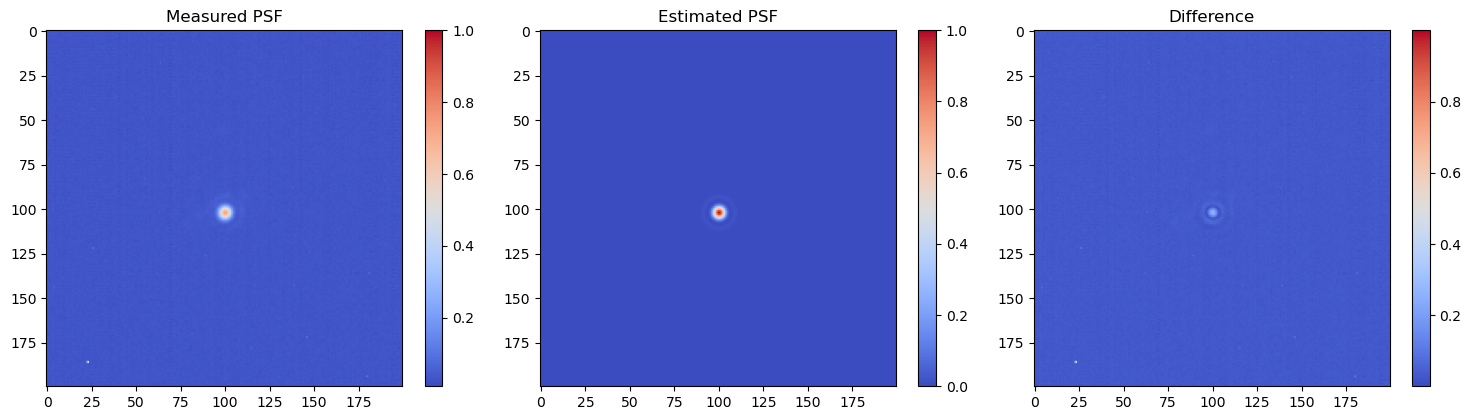

In [52]:
mpsf = np.load(r"C:\Users\willi\OneDrive - The Webb Schools\Documents\BME Year 3\Build_Imager\Lab3\wide_aperture_avg.npy")
mpsf /= np.max(mpsf)
mode_indices = [2, 3]  
x0 = [0.3, 0.01, -0.01] 
sigma0 = 0.05
opts = {'tolfun': 1e-10, 'tolx': 1e-5, 'popsize': 12, 'verb_disp': 1}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
fit = np.empty(opts['popsize'])

while not es.stop():
    new_solutions = es.ask()
    for i, sol in enumerate(new_solutions):
        fit[i] = objfunc(sol, mpsf, mode_indices)
    es.tell(new_solutions, fit)
    es.disp(1)
xopt = es.result[0]

# Results
xopt = es.result[0]
r_opt, tilt_x, tilt_y = xopt
print("Estimated exit pupil size (r):", r_opt)
print("Estimated coefficients: [ x-tilt = ", tilt_x, ", y-tilt = ", tilt_y, "]")

est_psf = make_psf(xopt, mode_indices, mpsf.shape[0])
est_psf = est_psf / np.max(est_psf)
show_optimization_result(mpsf, est_psf)

<div class="alert alert-block alert-success">
<font color=black>

3. Now, let’s consider a **defocused data set**. Select/collect a defocused PSF with a small to moderate level of defocus. Fix the aperture to the value you just calculated and estimate the level of defocus (and tilts, since they remain important). Show your measured PSF, estimated PSF, and state your estimated defocus.

</font> 
</div>

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 4 (seed=699790, Fri Apr 25 10:59:49 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 4.860584545471083e+01 1.0e+00 4.13e-02  4e-02  4e-02 0:00.1
    2     24 4.819928369112809e+01 1.4e+00 3.86e-02  3e-02  4e-02 0:00.1
    3     36 4.774986496690924e+01 1.8e+00 5.22e-02  5e-02  6e-02 0:00.2
    4     48 4.636914198672542e+01 2.5e+00 6.20e-02  5e-02  7e-02 0:00.3
    5     60 4.596403052097671e+01 2.8e+00 7.11e-02  6e-02  9e-02 0:00.3
    6     72 4.598085256000883e+01 3.1e+00 7.72e-02  6e-02  1e-01 0:00.4
    7     84 4.598646956903832e+01 3.7e+00 8.30e-02  7e-02  1e-01 0:00.5
    8     96 4.517452781073050e+01 4.1e+00 8.09e-02  8e-02  1e-01 0:00.6
    9    108 4.499259918768571e+01 4.6e+00 8.89e-02  9e-02  1e-01 0:00.6
   10    120 4.559987892453151e+01 5.8e+00 7.99e-02  8e-02  1e-01 0:00.7
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    132 4.461952944001519e+01 

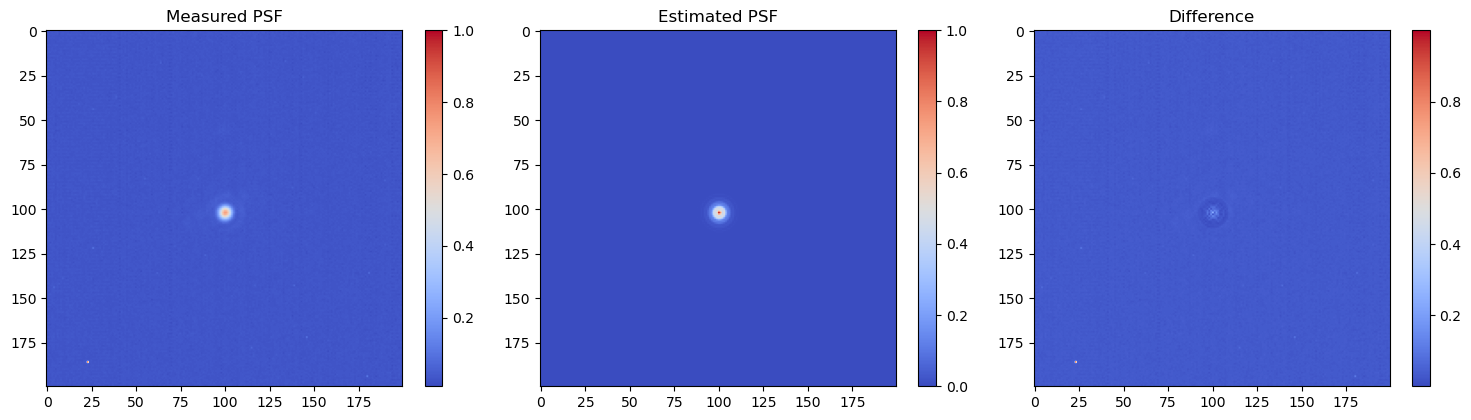

In [49]:
unfocus = np.load(r"C:\Users\willi\OneDrive - The Webb Schools\Documents\BME Year 3\Build_Imager\Lab3\blue_unfocus.npy")
unfocus /= np.max(unfocus)

mode_indices = [2, 3, 4]  
x0 = [0.3, 0.01, -0.01, 0.3] 
sigma0 = 0.05
opts = {'tolfun': 1e-10, 'tolx': 1e-5, 'popsize': 12, 'verb_disp': 1}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
fit = np.empty(opts['popsize'])

while not es.stop():
    new_solutions = es.ask()
    for i, sol in enumerate(new_solutions):
        fit[i] = objfunc(sol, mpsf, mode_indices)
    es.tell(new_solutions, fit)
    es.disp(1)
xopt = es.result[0]

# Results
xopt = es.result[0]
r_opt, tilt_x, tilt_y, focus = xopt
print("Estimated exit pupil size (r):", r_opt)
print("Estimated coefficients: [ x-tilt = ", tilt_x, ", y-tilt = ", tilt_y, ", defocus = ", focus, "]")

est_psf = make_psf(xopt, mode_indices, mpsf.shape[0])
est_psf = est_psf / np.max(est_psf)
show_optimization_result(mpsf, est_psf)

<div class="alert alert-block alert-success">
<font color=black>

4. Repeat the above estimation but include astigmatism (4), coma (7), and spherical aberration (8) Zernikes. Show your measured PSF, estimated PSF, and state your estimated aberration parameters. Additionally, show the resulting pupil phase function (e.g. the weighted sum of these Zernikes that fits this data). Are these estimates different than the previous fit?
</font> 
</div>

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 4 (seed=706919, Fri Apr 25 10:59:56 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 4.885286284569590e+01 1.0e+00 5.16e-02  5e-02  5e-02 0:00.1
    2     24 4.797670926660538e+01 1.6e+00 5.25e-02  4e-02  5e-02 0:00.2
    3     36 4.744398515898013e+01 1.8e+00 5.69e-02  5e-02  6e-02 0:00.2
    4     48 4.409111375101274e+01 2.2e+00 6.52e-02  6e-02  8e-02 0:00.3
    5     60 4.425731887988380e+01 3.2e+00 8.66e-02  9e-02  1e-01 0:00.4
    6     72 4.401985858820990e+01 3.2e+00 8.04e-02  7e-02  8e-02 0:00.5
    7     84 4.435284377917561e+01 3.4e+00 8.06e-02  7e-02  9e-02 0:00.5
    8     96 4.332034211263627e+01 4.0e+00 6.69e-02  6e-02  7e-02 0:00.6
    9    108 4.357236526885480e+01 4.4e+00 7.09e-02  6e-02  7e-02 0:00.7
   10    120 4.325020236435432e+01 6.0e+00 7.32e-02  6e-02  7e-02 0:00.8
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    132 4.416458489507524e+01 

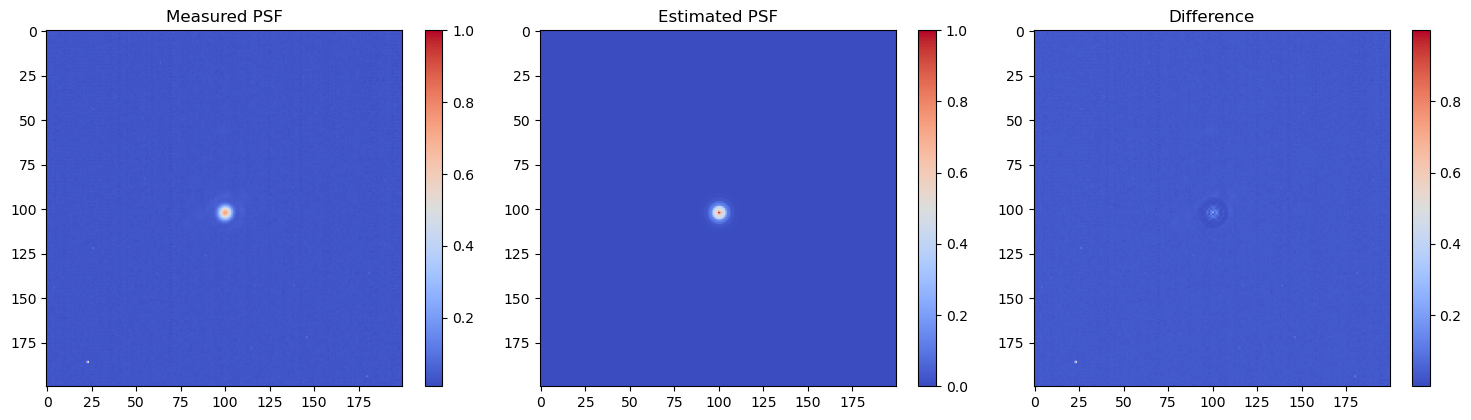

In [ ]:
unfocus = np.load(r"C:\Users\willi\OneDrive - The Webb Schools\Documents\BME Year 3\Build_Imager\Lab3\blue_unfocus.npy")
unfocus /= np.max(unfocus)

mode_indices = [2:8, 11]  
x0 = [0.3, 0.01, -0.01, 0.3] 
sigma0 = 0.05
opts = {'tolfun': 1e-10, 'tolx': 1e-5, 'popsize': 12, 'verb_disp': 1}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
fit = np.empty(opts['popsize'])

while not es.stop():
    new_solutions = es.ask()
    for i, sol in enumerate(new_solutions):
        fit[i] = objfunc(sol, mpsf, mode_indices)
    es.tell(new_solutions, fit)
    es.disp(1)
xopt = es.result[0]

# Results
xopt = es.result[0]
r_opt, tilt_x, tilt_y, focus = xopt
print("Estimated exit pupil size (r):", r_opt)
print("Estimated coefficients: [ x-tilt = ", tilt_x, ", y-tilt = ", tilt_y, ", defocus = ", focus, "]")

est_psf = make_psf(xopt, mode_indices, mpsf.shape[0])
est_psf = est_psf / np.max(est_psf)
show_optimization_result(mpsf, est_psf)

<div class="alert alert-block alert-success">
<font color=black>

5. Repeat the above estimation once more but use all Zernike polynomials from 2-22. Show your measured PSF, estimated PSF, and state your estimated aberration parameters. Show the resulting pupil phase function. Are these estimates different than the previous ones? Lastly, show the pupil phase function for a perfectly focused system (i.e., zero out the defocus and x-,y-tilt terms and show the weighted sum of all other Zernike polynomials).
</font> 
</div>

<div class="alert alert-block alert-success">
<font color=black>

6. Collect an additional defocused data set (different than the one above). Try to reproduce the “1-wave” defocus case that you simulated previously where the center of the PSF is near-zero and the PSF has the form of an annulus (i.e., donut-shape). Conduct the estimation using Zernikes 2-22. Show the estimated pupil phase function. Also, show the pupil phase function for a perfectly focused system. How does this compare with the previous “perfect focus” estimate.
</font> 
</div>

In [51]:
# recollect data to get donut shape

<div class="alert alert-block alert-success">
<font color=black>

**BONUS #1** Repeat a defocus experiment using another wavelength filter. Show pupil phase functions and “perfect focus” estimates. How do these compare to previous estimates?
    
**BONUS #2** Estimating the Pupil Function in an Obstructed Imaging System

Many optical imaging systems do not have simple disc-shaped pupil functions. This is true in astronomical imaging devices including telescopes with central obstructions (typically to suspend a secondary mirror in the optical path, which allows a longer “b” distance in the lens equation (or “zi” more recently) while maintaining a compact optical instrument, effectively “folding” the optical path).
We will set up a microscope where a central obstruction has been placed in the pupil. Alter your make_psf code to allow for three addition parameters for the amplitude portion of your pupil function. Specifically, allow a disc-shaped central obstruction of unknown position (x,y) and unknown diameter. For the datasets that you acquire show measured and estimated PSFs, amplitude and phase of your pupil function, and estimated aberration parameters. (You may select Zernikes based on your previous characterizations of the microscope.)

</font> 
</div>